# NBA Power Rankings via Page Rank
This notebook provides an example of using the Page Rank algorithm (Google's first website ranking algorithm), trying to rank NBA teams based on their results during the Regular Season.

NBA Games data for the 2020/21 Regular Season obtained using [nba_api](https://github.com/swar/nba_api/), which can be easily installed with PIP `(pip install nba_api)`.

In [1]:
# Importing endpoints for the NBA API and libraries that we will use.
from nba_api.stats.endpoints import teamgamelogs
import numpy as np
import pandas as pd

In [2]:
# Data obtention by reading the documentation available in
# https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/teamgamelogs.md
df = teamgamelogs.TeamGameLogs(season_nullable="2020-21").get_data_frames()[0]

In [3]:
df.head()

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK
0,2020-21,1610612764,WAS,Washington Wizards,0022001080,2021-05-16T00:00:00,WAS vs. CHA,W,48.0,44,...,170,1454,1048,1867,1499,1024,1160,1786,836,789
1,2020-21,1610612737,ATL,Atlanta Hawks,0022001066,2021-05-16T00:00:00,ATL vs. HOU,W,48.0,49,...,67,146,826,348,155,1024,376,1220,354,60
2,2020-21,1610612758,SAC,Sacramento Kings,0022001077,2021-05-16T00:00:00,SAC vs. UTA,L,48.0,42,...,1630,1099,826,348,801,332,1552,1915,1817,2000
3,2020-21,1610612740,NOP,New Orleans Pelicans,0022001072,2021-05-16T00:00:00,NOP vs. LAL,L,48.0,37,...,656,775,2041,1867,801,1024,725,1609,1862,1693
4,2020-21,1610612757,POR,Portland Trail Blazers,0022001076,2021-05-16T00:00:00,POR vs. DEN,W,48.0,46,...,278,1099,1048,2016,490,141,376,786,115,280


## Using our DataFrame
We will be using each team's abbreviation to create our sub dataframes. For each game played in the season, we have 2 rows, each corresponding to stats for the participating team, we will just use columns TEAM_ABBREVIATION and WL, grouping by Game ID.

We will create a row for each Game, and create a DataFrame with 4 columns:
- First Team, Last Team (or second team) with the abbreviations of the teams that faced each other.
- First Team Win and Last Team Win with a 1 if the First/Last Team won the match and a 0 if they didn't.

For example, the row corresponding to the game with ID 1610612760 (OKC vs LAC, OKC won) would be:

OKC - LAC - 1 - 0

In [4]:
games = df.groupby("GAME_ID").agg({"TEAM_ABBREVIATION": ["first", "last"], "WL": ["first", "last"]})

In [5]:
games["WL"] = (games["WL"] == "W").astype(int)
games.columns = ["first_team", "last_team", "first_win", "last_win"]
games.head()

,first_team,last_team,first_win,last_win
GAME_ID,,,,
0022000001,BKN,GSW,1,0
0022000002,LAC,LAL,1,0
0022000003,BOS,MIL,1,0
0022000004,DAL,PHX,0,1
0022000005,NOP,MIA,0,1


## PAGERANK
We need to prepare our matrix $A$, whose $A_{i,j}$ will represent a proxy of the probability that team $i$ beats team $j$, based on all the games they played with each other (we will not take into account home-court advantage).

For example, if Atlanta and Brooklyn faced each other 3 times and Brooklyn won 2 of those matches, then $A_{BKN, ATL} = 2/3$ and $A_{ATL, BKN} = 1/3$

We can create this matrix using Pandas' [pivot_table function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html).

In [6]:
# Using information from the first team victories when pivoting.
first_win_mat = games.pivot_table(
    index="first_team", columns="last_team", values="first_win", aggfunc="sum"
).fillna(0)
# Last team victories pivot matrix needs to be transposed.
last_win_mat = games.pivot_table(
    index="first_team", columns="last_team", values="last_win", aggfunc="sum"
).fillna(0)
# We sum both matrices to get A and divide by the amount of games each team played (72 for this season,
# for which we can make a constant based on the amount of games downloaded and participating teams) to
# make our matrix adjust to the Perron-Frobenius Theorem (http://people.math.harvard.edu/~knill/teaching/math19b_2011/handouts/lecture34.pdf). 
win_losses = first_win_mat + last_win_mat.T
games_played = len(games) / 15
win_loss_prob = win_losses / games_played

In [7]:
# We create a function that applies the Power Method via Rayleigh's coefficient with any starting vector
# we choose. This will help us find the eigenvector related to the biggest eigenvalue in our matrix,
# which will provide us with the Page Rank of each team.
def autrayleigh(A, q_zero, tol):
    q = q_zero / np.linalg.norm(q_zero, 2)
    theta = tol + 1
    while abs(theta) > tol:
        rho = np.dot(q, A@q)
        q_hat = q
        I = np.eye(A.shape[0])

        z = np.linalg.solve(A-rho*I, q_hat)
        sigma = np.linalg.norm(z, 2)
        q = z / sigma
        theta = np.dot(q, q_hat) / sigma

    return q, rho + theta

In [8]:
# We can use a dampening factor to change our PageRank Matrix, but this example works well without it.
pr_mat = win_loss_prob
# Our initial vector is [1/30, ..., 1/30]
start_vec = np.ones(30) / 30
# We apply the Power method now
end_vec, lam = autrayleigh(pr_mat, start_vec, tol=1e-5)

In [9]:
# We create a dataframe with the PR Score for each team and we sort it (ascending, to make the plot easier)
pr_score = pd.DataFrame(index=pr_mat.index.values, data=end_vec).sort_values(by=0, ascending=True)
pr_score.columns = ["PR Score"]
pr_score.tail()

,PR Score
LAC,0.233709
PHI,0.236050
BKN,0.244496
UTA,0.257926
PHX,0.263816


<AxesSubplot:title={'center':'PR Score for the best 16 teams'}>

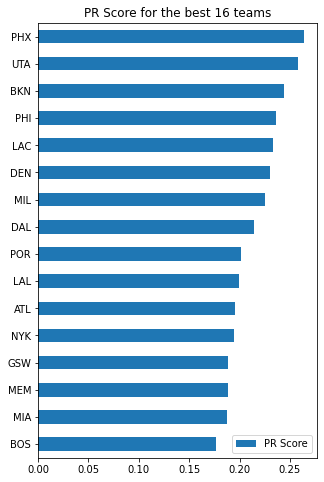

In [10]:
# Let's plot the best 16 teams!
pr_score.iloc[-16:].plot.barh(figsize=(5,8), title="PR Score for the best 16 teams")

## Conclusions
Page Rank provides us with a not-so-difficult way to rank the NBA Teams according to the results they had in the Regular Season. We can make some quick assessments about this ranking:
- Page Rank considers Atlanta is better than New York, so it is no surprise that the Hawks advanced to the Conference Semifinals.
- Even if Anthony Davis's injury helped the Phoenix Suns, the difference between both teams was big.
- The surprises for the current 2020/21 postseason were the Bucks upsetting Brooklyn (with Harden and Irving's injuries), Atlanta beating the Sixers and the Clippers winning against Utah.

According to Page Rank, The Suns should be the NBA Champions, let's see what happens with that... This is a really simple model, we can make it a bit more complex by adding some recency coefficient to assign more importance to the latest matches (seasons are long, first results don't really count as much as the last games played) or balancing for games that had important absences (maybe using some coefficient that depends on the Win Shares of each player or their WARP).